In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num
from datetime import timedelta

from scipy.stats import pearsonr 

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [96]:
import sys,os
sys.version

path = sys.path[0] + '/data/'
result_path = path + 'results/'
input_path = path+'stocks_input.xls'
external_stock_input_path = path + 'external_stocks.txt'
if not os.path.exists(result_path):
    os.mkdir(result_path)

In [97]:
training_window = 60
prediction_window = 5

target_prediction_indices = (0,-3,-2)

cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [98]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    # Compute the logarithmic returns using the Closing price 
    data['Log_Ret'] = np.log(data['close'] / data['close'].shift(100))

    # Compute Volatility using the pandas rolling standard deviation function
    data['volatility'] = data['Log_Ret'].rolling(window=100 ).std() * np.sqrt(21)
    
    #Compute the Sharpe Ratio 
    data["Sharpe Ratio"] = data["Log_Ret"]/df["volatility"]
    
    return data.dropna()

In [99]:
def plot_chart(data, n, fileName="Current Portfolio", save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(result_path + fileName + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [100]:
def load_external_stocks(path):
    f = open(path)
    a = f.readlines()
    a = [i.rstrip() for i in a]
    return a

load_external_stocks(external_stock_input_path)

['BATAINDIA.NS', 'TECHM.NS']

In [101]:
def load_stocks(path):
    _df = pd.read_excel(path)
    return _df.set_index("Ticker").to_dict()

stdf = load_stocks(path+'stocks_input.xls')
stdf


# stdf = pd.DataFrame(stocks, index=["Allocation"])
# stdf.to_excel(path+'stocks_input.xls')

{'YESBANK.NS': {'Allocation': 0.2},
 'TATAMOTORS.NS': {'Allocation': 0.2},
 'HDFCBANK.NS': {'Allocation': 0.2},
 'RELIANCE.NS': {'Allocation': 0.2},
 'BAJAJ-AUTO.NS': {'Allocation': 0.2}}

In [102]:
# sts = stdf.set_index("Ticker").to_dict()
# for i in sts.keys():
#     print(i,sts.get(i).get("Allocation"))

In [103]:
#2005-07-28

input_path = path+'stocks_input.xls'

stocks = load_stocks(input_path)#{"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
stocks_df = {}
df = None
# indices = set([])

for stock in stocks.keys():
    print("pulling data for ", stock)
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    stocks_df[stock] = _df
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock).get("Allocation")
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock).get("Allocation")

df.head()

pulling data for  YESBANK.NS
pulling data for  TATAMOTORS.NS
pulling data for  HDFCBANK.NS
pulling data for  RELIANCE.NS
pulling data for  BAJAJ-AUTO.NS


,open,high,low,close,volume
2014-03-06,628.081607,638.491002,625.005597,636.040002,12037351.6
2015-08-07,832.565015,837.938000,821.528998,826.717978,4622382.4
2015-02-24,775.510406,780.433203,766.671606,772.895990,6765507.4
2020-05-15,1030.480000,1036.689995,1010.039996,1024.840029,20708289.0
2019-02-26,1099.063998,1117.040009,1092.230011,1109.403998,26292475.0


In [104]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [105]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2014-03-06,628.081607,638.491002,625.005597,636.040002,12037351.6
1,2015-08-07,832.565015,837.938000,821.528998,826.717978,4622382.4
2,2015-02-24,775.510406,780.433203,766.671606,772.895990,6765507.4
3,2020-05-15,1030.480000,1036.689995,1010.039996,1024.840029,20708289.0
4,2019-02-26,1099.063998,1117.040009,1092.230011,1109.403998,26292475.0


In [106]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-16 00:00:00'))

In [107]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
97,2012-07-17,489.187798,490.422797,474.443987,477.990608,5544065.4
95,2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6
24,2012-09-24,576.886795,584.995999,573.059000,578.213991,11021497.6
21,2012-12-12,627.272800,639.786198,625.425598,636.832207,4894235.0
42,2013-01-31,641.925810,650.845586,635.405798,638.253609,5995136.6
...,...,...,...,...,...,...
76,2020-07-21,1246.210010,1264.219990,1236.960000,1248.430029,27525411.8
15,2020-08-19,1291.700000,1305.240009,1273.290020,1279.780015,65701855.8
93,2020-11-04,1228.380001,1258.190010,1219.119980,1248.970013,27978410.6
69,2020-11-13,1305.010010,1323.660015,1296.730021,1311.370016,59491970.8


['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio'] ['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio']


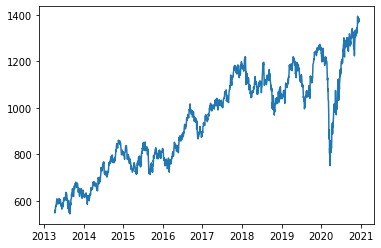

In [108]:
if "Date" in df.columns:
    df.sort_values("Date", inplace=True)
    df= df.set_index("Date")
#     df.index = df.index.sort_values()
    split_date = '2020-01-01'

    df = get_indicators(df)
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]
    df_data_test = df[df.index >= split_date]
    
plt.plot(df.index,df["open"])

print(df.columns.to_list() , df_data_training.columns.to_list())
# df.head()

In [109]:
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2013-04-09,552.910202,556.588394,544.042201,549.439191,7516458.0,-19.100873,-17.587090,-1.513782,558.080299,591.424200,28.953101,16.576452,-0.067290,0.440809,-0.152651
2013-04-10,548.529591,557.185002,545.237993,555.579199,6435550.6,-18.155019,-17.700676,-0.454343,556.303578,588.898273,34.229528,16.245777,-0.044446,0.449421,-0.098895
2013-04-11,560.019998,562.732797,549.510406,553.878603,8542662.8,-17.342731,-17.629087,0.286356,554.529279,587.096000,33.487710,16.029821,-0.034822,0.456932,-0.076209
2013-04-12,549.156801,561.877991,547.306198,558.253001,5555212.8,-16.159730,-17.335216,1.175486,553.339598,585.154787,37.254577,15.925676,-0.040025,0.464543,-0.086160
2013-04-15,554.620996,567.554004,552.588399,559.999985,7132245.6,-14.909361,-16.850045,1.940684,552.704756,583.344800,38.746560,15.857100,-0.029734,0.471096,-0.063117


In [110]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2013-04-09,552.910202,556.588394,544.042201,549.439191,7516458.0,-19.100873,-17.587090,-1.513782,558.080299,591.424200,28.953101,16.576452,-0.067290,0.440809,-0.152651
2013-04-10,548.529591,557.185002,545.237993,555.579199,6435550.6,-18.155019,-17.700676,-0.454343,556.303578,588.898273,34.229528,16.245777,-0.044446,0.449421,-0.098895
2013-04-11,560.019998,562.732797,549.510406,553.878603,8542662.8,-17.342731,-17.629087,0.286356,554.529279,587.096000,33.487710,16.029821,-0.034822,0.456932,-0.076209
2013-04-12,549.156801,561.877991,547.306198,558.253001,5555212.8,-16.159730,-17.335216,1.175486,553.339598,585.154787,37.254577,15.925676,-0.040025,0.464543,-0.086160
2013-04-15,554.620996,567.554004,552.588399,559.999985,7132245.6,-14.909361,-16.850045,1.940684,552.704756,583.344800,38.746560,15.857100,-0.029734,0.471096,-0.063117


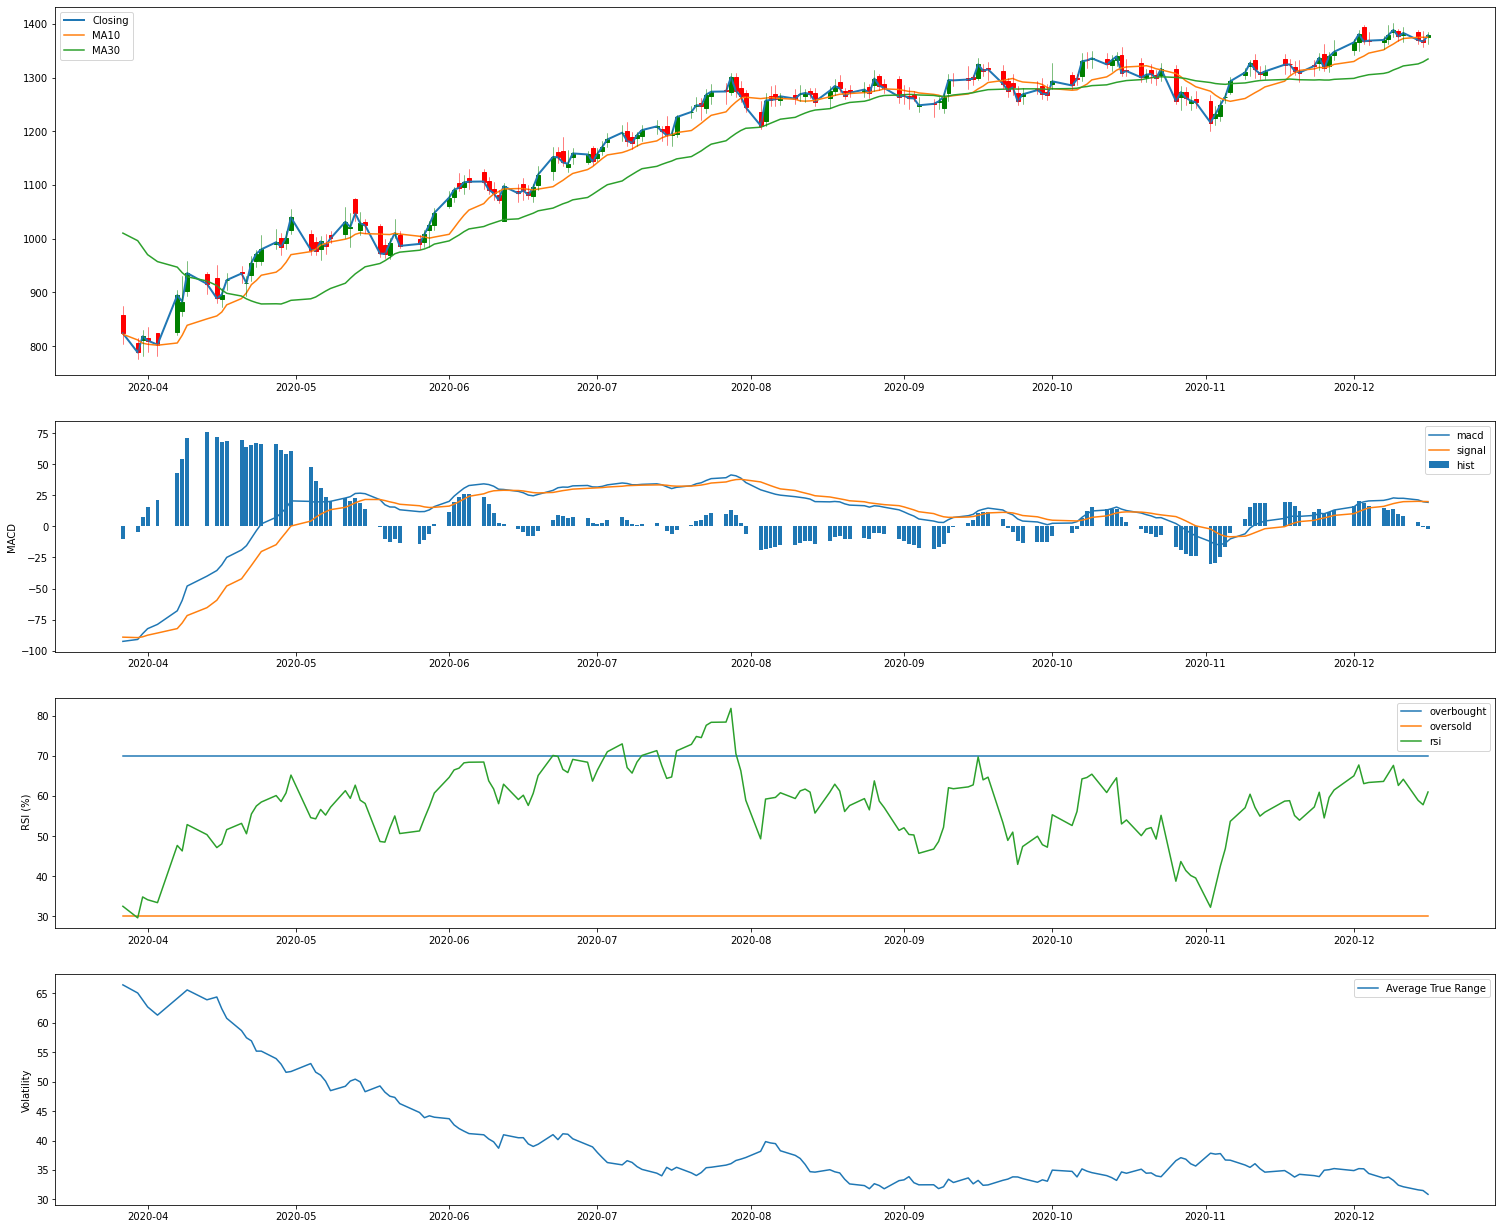

In [111]:
# _df = df.set_index("Date")
plot_chart(df, 180, 'Current Portfolio', save=True)

Training Size : 1652, Test Size : 240


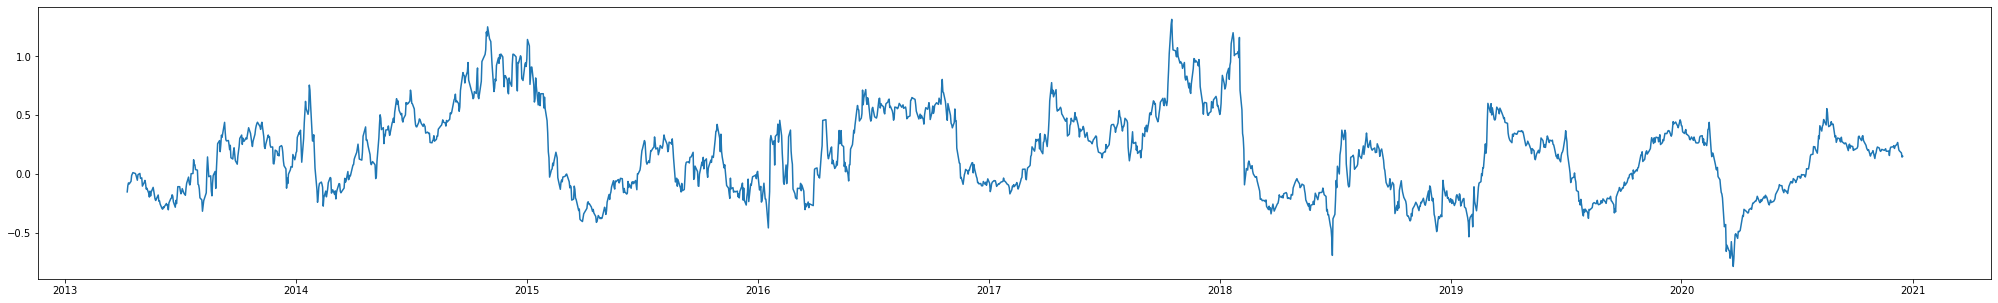

In [112]:
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )
df.head()
plt.figure(figsize=(35,5))
plt.plot(df.index, df["Sharpe Ratio"])

In [113]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

## Scaler

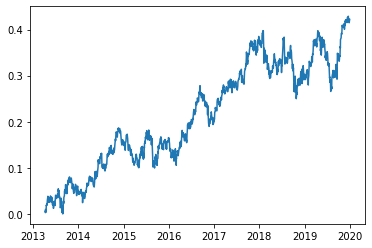

In [114]:
scaler = MinMaxScaler(feature_range=(0,0.5))
scaler.fit(df)

training_Dataset = scaler.transform(data_training)
_scale = [1/scaler.scale_[i] for i in target_prediction_indices]
_intercept = [scaler.data_min_[i] for i in target_prediction_indices]

plt.plot(data_training.index, training_Dataset[:,0])

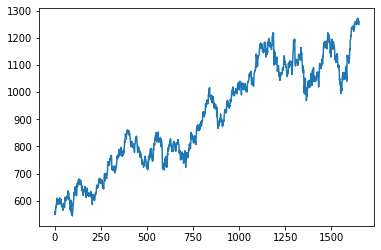

In [115]:
_df = scaler.inverse_transform(training_Dataset)
plt.plot(_df[:,0])
# _df

1652 1892


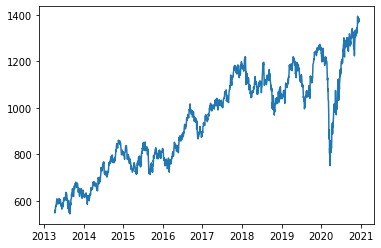

In [116]:
print(len(data_training), len(df))
plt.plot(df.index,df["open"])

## Training Pipeline

In [117]:
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]-prediction_window):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i+prediction_window,target_prediction_indices])
X_train, y_train = np.array(X_train), np.array(y_train)

In [118]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1587, 60, 15), Shape of Y is : (1587, 3)


In [119]:
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of data_training.index (1592,)


In [120]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 0.0070:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [121]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,15)),
    Dropout(0.4),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=70, activation='relu'),
    Dropout(0.3),
    Dense(3)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 120)           65280     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            54720     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 70)               

In [122]:
model_name = path + "portfolio_predictor_5.hdf5"
model.load_weights(model_name)
model_name

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/data/portfolio_predictor_5.hdf5'

In [123]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError(),metrics=["accuracy"])
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=40, callbacks = CustomCallback())

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9200
Final Loss : 0.004825663287192583
50/50 [==============================] - 7s 131ms/step - loss: 0.0048 - accuracy: 0.9200


In [124]:
# model.save(model_name)
# scaler.data_min_[0]
test_pred = model.predict(X_train)
test_pred * _scale + _intercept
# test_pred

array([[6.16767994e+02, 6.57962621e-02, 3.01992482e-01],
       [6.16924134e+02, 6.65577552e-02, 3.01880345e-01],
       [6.17096186e+02, 6.74481048e-02, 3.01773268e-01],
       ...,
       [1.21153513e+03, 3.13327963e-02, 3.37657904e-01],
       [1.21141199e+03, 3.09522071e-02, 3.37928848e-01],
       [1.21130488e+03, 3.06008262e-02, 3.38181710e-01]])

In [125]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred
test_pred = test_pred * _scale + _intercept
y_train = y_train * _scale + _intercept

y_train

50/50 [==============================] - 2s 30ms/step - loss: 0.0011 - accuracy: 0.9420


array([[ 6.08179591e+02, -2.69286782e-02,  3.40578438e-01],
       [ 6.07900787e+02, -9.00031649e-03,  3.36083670e-01],
       [ 6.08767209e+02, -2.51406498e-02,  3.31094856e-01],
       ...,
       [ 1.24915000e+03,  1.86514334e-01,  4.74289290e-01],
       [ 1.25860999e+03,  2.22040650e-01,  4.82298027e-01],
       [ 1.26124999e+03,  2.17563273e-01,  4.88787057e-01]])

In [126]:
y_train[:,2]

array([0.34057844, 0.33608367, 0.33109486, ..., 0.47428929, 0.48229803,
       0.48878706])

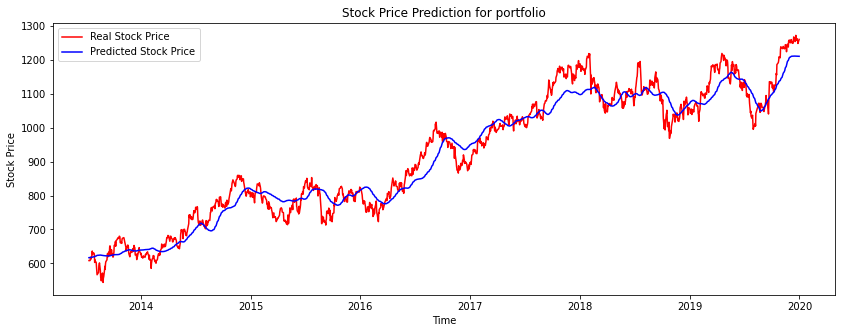

In [127]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window+prediction_window:], y_train[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window+prediction_window:], test_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,y_train.max()*1.1)
plt.savefig(result_path + "training_output.jpeg", dpi=300)
plt.show()

In [128]:
past_60_days = df_data_training.tail(training_window)
df_data_test.shape

(240, 15)

In [129]:

df_test = past_60_days.append(df_data_test).sort_index()
df_test.dropna(inplace=True)
df_test.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2019-10-01,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373,-0.049109,0.407729,-0.120446
2019-10-03,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703,-0.028057,0.404647,-0.069337
2019-10-04,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080,-0.038763,0.402544,-0.096296
2019-10-07,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576,-0.028916,0.399248,-0.072427
2019-10-09,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678,-0.013274,0.396355,-0.033491


In [130]:
inputs = scaler.transform(df_test)
inputs

array([[0.34751653, 0.35024853, 0.34252703, ..., 0.21543788, 0.14793497,
        0.1585339 ],
       [0.33755751, 0.34151733, 0.34057867, ..., 0.22540478, 0.14639182,
        0.17069108],
       [0.34350118, 0.34243547, 0.33772425, ..., 0.22033596, 0.14533904,
        0.16427833],
       ...,
       [0.49396226, 0.49237057, 0.49295869, ..., 0.28281242, 0.20510072,
        0.22966134],
       [0.48570229, 0.49136355, 0.48886063, ..., 0.27416306, 0.20579919,
        0.22124384],
       [0.48945897, 0.49055797, 0.49250269, ..., 0.27612455, 0.20661721,
        0.22301519]])

In [131]:
X_test = []
y_test = []

for i in range(training_window, inputs.shape[0]-prediction_window):
    X_test.append(inputs[i-training_window:i])
    y_test.append(inputs[i+prediction_window, target_prediction_indices])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((235, 60, 15), (235, 3))

In [132]:
y_pred = model.predict(X_test)
y_pred.shape

(235, 3)

In [133]:
scaler.scale_

array([5.87899434e-04, 5.92347856e-04, 5.92204038e-04, 5.95529770e-04,
       2.14383349e-09, 3.45728266e-03, 3.92306827e-03, 1.04288650e-02,
       6.08084431e-04, 6.56816575e-04, 6.85948546e-03, 9.13731319e-03,
       4.73436566e-01, 5.00639456e-01, 2.37868840e-01])

In [134]:
y_pred = y_pred* _scale + _intercept
y_test = y_test* _scale + _intercept
y_pred.shape

(235, 3)

In [135]:
model.evaluate(X_test,  y_test)

8/8 [==============================] - 0s 30ms/step - loss: 466109.2188 - accuracy: 1.0000


[466109.21875, 1.0]

In [136]:
y_test.max()

1394.069990158081

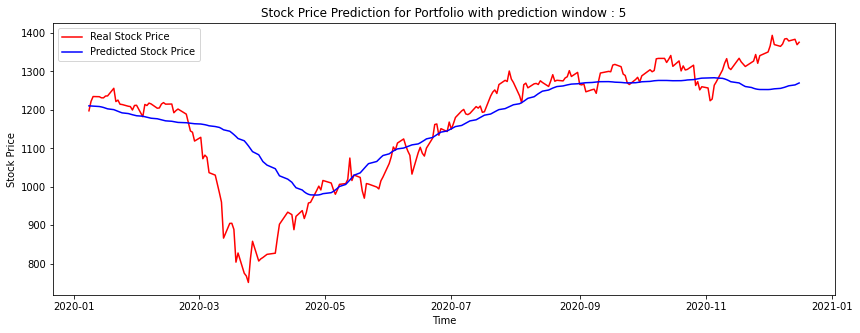

In [137]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df_test.index[training_window+prediction_window:], y_test[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(df_test.index[training_window+prediction_window:], y_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio with prediction window : '+ str(prediction_window))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
y_test
# plt.ylim(0,y_test.max()*1.1)
plt.savefig(result_path + "test_output.jpeg", dpi=300)
plt.show()

## Updated Portfolio Analysis and Co-relation

In [138]:
def analyze_portfolio(stocks_df_ticker, external_stock_ticker, num_iterations=1000,show_figure=True):
    
    stocks_df = {}
    
    for stock in stocks.keys():
        # print("pulling data for ", stock)
        _df = si.get_data(stock)
        _df.dropna(inplace=True)
        stocks_df[stock] = _df

    analyze_stocks_df = stocks_df.copy()
    if external_stock_ticker:
        for stock in external_stock_ticker:
            # print("pulling data for ", stock)
            analyze_stocks_df[stock] = si.get_data(stock)
        
    stock = list(analyze_stocks_df.keys())
    num_stocks = len(stock)
    
    df = None
    for st in stock:
        if df is None:
            df = analyze_stocks_df[st].copy()
            df[st] = (df["open"] + df["close"])/2
            df = pd.DataFrame(df[st])
        else:
            _df = analyze_stocks_df[st]
            df[st] = (_df["open"] + _df["close"])/2
    df.dropna(inplace=True)   

    #Analyze stocks 
    stock_ret = df.pct_change()*100

    mean_returns = stock_ret.mean()
    cov_matrix = stock_ret.cov()


    simulation_res = np.zeros((4+num_stocks-1,num_iterations))

    for i in range(num_iterations):
    #Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(num_stocks))
        weights /= np.sum(weights)
    #Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    #Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
    #Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
    #Save the weights in the array
        for j in range(len(weights)):
            simulation_res[j+3,i] = weights[j]
    sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe']+stock)
    
    #Spot the position of the portfolio with highest Sharpe Ratio
    max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

    #Spot the position of the portfolio with minimum Standard Deviation
    min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]

    if show_figure:
        plt.figure()
        plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
        plt.xlabel('Standard Deviation')
        plt.ylabel('Returns')
        plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=200, label="Maximum Sharpe Ratio")
        plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=200, label="Minimum Standard Deviation")
        plt.legend()
        plt.savefig(result_path + ",".join(external_stock_ticker) + ".jpeg", dpi=300)
        plt.close()
    max_sharpe = simulation_res[2,:].max()

    for it in range(num_iterations):
        if simulation_res[2,it] == max_sharpe:
            break

    a = list(zip(stock,simulation_res[:,it][-num_stocks:]))
    extended_stock_df = dict(a)
    fig = plt.figure()
    plt.pie([val for key,val in extended_stock_df.items()], labels=[key for key,val in extended_stock_df.items()], autopct=None)
    print("Saving fig for ", str(external_stock_ticker ))
    plt.savefig(result_path + "Optimized portfolio - "+",".join(external_stock_ticker) + ".jpeg", dpi=300)
    plt.close()
    return extended_stock_df

In [139]:
def projected_returns_with_optimised_portfolio(extended_stock_df_tickers, ):
    df = None
    for stock in extended_stock_df.keys():
        _df = si.get_data(stock)
        _df.dropna(inplace=True)
        stocks_df[stock] = _df
        if df is None:
            df = _df[cols_to_keep]*extended_stock_df.get(stock)
            indices = set(df.index.astype('str').tolist())
        else:
            indices = indices.intersection(set(_df.index.astype('str').tolist()))
            df = df.loc[indices]
            _df = _df.loc[indices]
            df[cols_to_keep] += _df[cols_to_keep]*extended_stock_df.get(stock)
    
    get_indicators(df)
    df.dropna(inplace=True)
    df = df.sort_index()
    dataset = scaler.transform(df)
    
    X = []
    for i in range(-prediction_window,0):
        X.append(dataset[i-training_window:i])
    
    Y = model.predict(np.array(X)) * _scale + _intercept
    dt = df.index[-prediction_window:] + timedelta(prediction_window)

    return dt, Y



Saving fig for  ['BATAINDIA.NS']
Saving fig for  ['TECHM.NS']


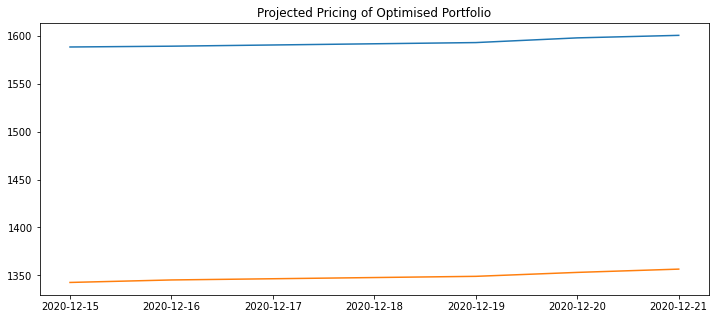

In [140]:
#Handle this : 

external_stock_ticker = path + 'external_stock_input.xls'

inportfolio_tickers = list(load_stocks(input_path).keys())
external_stock_ticker = load_external_stocks(external_stock_input_path)
projected_returns = {}

for st in external_stock_ticker:
    extended_stock_df = analyze_portfolio(inportfolio_tickers, [st])
    dt, Y = projected_returns_with_optimised_portfolio(extended_stock_df)
    projected_returns[st] = [dt,Y]

fig = plt.figure(figsize=(12,5))
plt.title("Projected Pricing of Optimised Portfolio")

for st in external_stock_ticker:
    _dt, _Y = projected_returns[st]
    plt.plot(_dt, _Y[:,0], label=st)
    plt.savefig(result_path + "Optimized portfolio projection"+ ".jpeg", dpi=300)

# projected_returns_with_optimised_portfolio(inportfolio_tickers +  [external_stock_ticker[0]])

## Asset Co-relation

In [141]:

def get_correlation(s1,s2):

    stock1 = stocks_df[s1]["close"][-training_window-prediction_window:]
    stock2 = stocks_df[s2]["close"][-training_window-prediction_window:]

    real = pearsonr(stock1, stock2)
    return real[0]

get_correlation('RELIANCE.NS', "YESBANK.NS")

-0.30743218905593267

In [142]:
list(stocks_df.keys())

['YESBANK.NS',
 'TATAMOTORS.NS',
 'HDFCBANK.NS',
 'RELIANCE.NS',
 'BAJAJ-AUTO.NS',
 'BATAINDIA.NS',
 'TECHM.NS']

In [143]:
index = list(stocks_df.keys())
data = {}

for st1 in index:
#     for st2 in index:
    data[st1] = [get_correlation(st1, st2) for st2 in index]

data['index'] = index
data = pd.DataFrame(data)
data.set_index('index', inplace=True)

In [144]:
data

,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS,BATAINDIA.NS,TECHM.NS
index,,,,,,,
YESBANK.NS,1.000000,0.805480,0.519242,-0.307432,0.829183,0.818877,0.702718
TATAMOTORS.NS,0.805480,1.000000,0.765250,-0.563538,0.851871,0.917680,0.777047
HDFCBANK.NS,0.519242,0.765250,1.000000,-0.812992,0.638350,0.738074,0.773875
RELIANCE.NS,-0.307432,-0.563538,-0.812992,1.000000,-0.357107,-0.517942,-0.518349
BAJAJ-AUTO.NS,0.829183,0.851871,0.638350,-0.357107,1.000000,0.904311,0.879732
BATAINDIA.NS,0.818877,0.917680,0.738074,-0.517942,0.904311,1.000000,0.844335
TECHM.NS,0.702718,0.777047,0.773875,-0.518349,0.879732,0.844335,1.000000


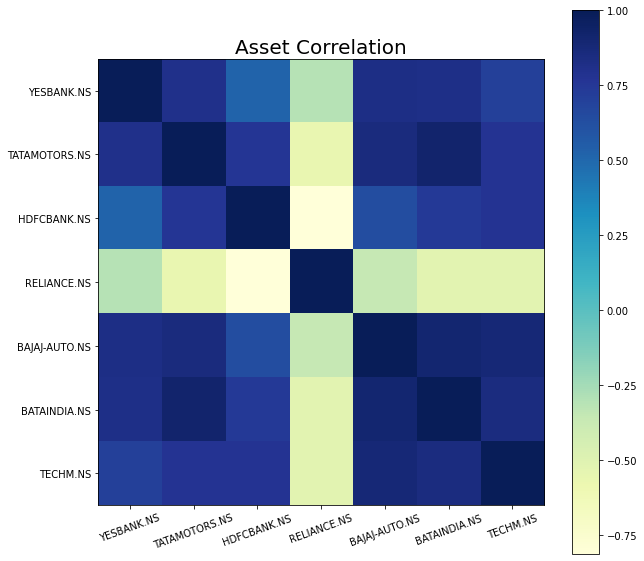

In [145]:
plt.figure(figsize=(10,10))
plt.title("Asset Correlation",fontsize=20)
plt.imshow(data, cmap="YlGnBu")
plt.colorbar()
plt.xticks(range(len(data)),data.columns, rotation=20)
plt.yticks(range(len(data)),data.index)

plt.savefig(result_path + "Asset Correlation Heat Map")